In [ ]:
#| default_exp datasets

In [ ]:
#|export
from __future__ import annotations
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

# pytorch
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
# huggingface
from datasets import load_dataset,load_dataset_builder

In [ ]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

`dataset_builder` has meta data on the dataset

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, dataset_name='fashion_mnist')}

In [ ]:
# [attr for attr in dir(ds_builder.info) if attr[:1] != '_']

In [ ]:
keys = [
    
    'builder_name',
    'config_name',
    'dataset_size',
    'description',
    'download_size',
    'features',
    'homepage',
    'license',
    'splits',
    'supervised_keys',
    'task_templates',   
    'version'
]

In [ ]:
for key in keys:
    print(f"{key:20s}:  {getattr(ds_builder.info, key)}")

builder_name        :  fashion_mnist
config_name         :  fashion_mnist
dataset_size        :  36530417
description         :  Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.

download_size       :  30878645
features            :  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}
homepage            :  https://github.com/zalandoresearch/fashion-mnist
license             :  
splits              :  {'train': SplitInfo(name='train', num_bytes=31296607, num_examples=6000

Now we download the dataset itself


In [ ]:
dsd = load_dataset(name)
# Downloading and preparing dataset fashion_mnist/fashion_mnist to a directory in .cache/huggingface/datsets ... 
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
dsd.cache_files

{'train': [{'filename': '/home/vtec/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/fashion_mnist-train.arrow'}],
 'test': [{'filename': '/home/vtec/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/fashion_mnist-test.arrow'}]}

We get a train and a test dataset

In [ ]:
train, test = dsd['train'], dsd['test']
train[0:3]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0]}

Each dataset has a property `features` returning a dictionary:

In [ ]:
train.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

keys/values: 
- `image`: `PIL` images
- `label`: labels

In [ ]:
# alias x and y for image and label
x, y = ds_builder.info.features.keys()
x, y

('image', 'label')

In [ ]:
x,y = ds_builder.info.features

In [ ]:
x,y

('image', 'label')

`dataset[index]['image]` same as `dataset[index][x]` return a list of images

In [ ]:
train[0]['image']

In [ ]:
img = train[0][x]
img

In [ ]:
xb = train[:5][x]
for img in xb:
    display(img)

`dataset[index]['label]` same as `dataset[index][y]` returns a list of labels as integers

In [ ]:
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

We can convert the `int` into text labels, using the method associated with the labels in this dataset


In [ ]:
train.features['label'].int2str

<bound method ClassLabel.int2str of ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)>

In [ ]:
train.features[y].int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [ ]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
train[y][:5]

[9, 0, 0, 3, 0]

HF often returns dictionaries and not tuple for the elements of a dataset.

Each element in the dataset is a dictionary `{'image': PIL.Image, 'label':value}`

In [ ]:
train.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
train[0]['image']

PyTorch can work with both dictionaries of tensors and tuples of tensors. 

But we have PIL.Images, so we need a collate function which takes each element in the dataset and returns a dict with 2 tensors

In [ ]:
# TF to access pytorch transforms functional API
TF

<module 'torchvision.transforms.functional' from '/home/vtec/miniconda3/envs/course22p2/lib/python3.10/site-packages/torchvision/transforms/functional.py'>

From pytorch [doc](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader):
- `collate_fn` (Callable, optional) – merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.

`collate_fn` function turns a list of single image tensors into one batch image tensor

In [ ]:
def collate_fn(b, key_x='image', key_y='label'):
    """returns an item as dictionary with key_x and key_y"""
    return {key_x:torch.stack([TF.to_tensor(o[key_x]) for o in b]),
            key_y:tensor([o[key_y] for o in b])}

In [ ]:
n=4
ds = [{'image':i, 'label':l} for i, l in zip(train['image'][:n], train['label'][:n])]

for o in ds:
    print(o)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 'label': 9}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 'label': 0}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 'label': 0}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 'label': 3}


In [ ]:
for o in ds:
    print(TF.to_tensor(o['image']).shape, o['label'])

torch.Size([1, 28, 28]) 9
torch.Size([1, 28, 28]) 0
torch.Size([1, 28, 28]) 0
torch.Size([1, 28, 28]) 3


In [ ]:
collate_fn(ds)

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
      

Also, we are not using transforms, ... but we put the entire pipeline in the `collate_fn`

In [ ]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

But we also could use a transform to make this more "abstracted"

`train.with_transform(transform_fctn)` will take the dataset train (each element `b`) and transforms it according to the `transform_fctn`. `b` is a dictionary, in our case with keys `image` and `label`

It expect the `transform_fctn` to return the transformed `b`. 

In our dataset, the labels are formatted as we want, but the images are `PIL` images and we want to get tensors. The transform will do that for us (modifying `b[x]`). Then we return the modified `b`

In [ ]:
# TF.to_tensor?

In [ ]:
def transforms(b, key_x='image'):
    b[key_x] = [TF.to_tensor(o) for o in b[key_x]]
    return b

In [ ]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b.keys(), b[x].shape, b[y]

(dict_keys(['image', 'label']),
 torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

Explanation of this in the lesson video [here](https://youtu.be/DYdvnzRk7Vs?t=5001)

Jeremy Howard prefers to write a function that only transforms, and then to use a decorator to wrap the function into a function that will return the batch

In [ ]:
# Just the transform. Then in cell lower, we will do the wrapping
def _transformi(b):
    """Takes the PIL images in the batch b, transforms them into tensors, and replace PIL by tensor in batch b"""
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
# b = train[:2].copy()
# print(b)
# _transformi(b)
# print(b)

Here we create our wrapping function
- the transform function does not return anything. It changes the PIL into tensor in placce `b[x] = [torch...`
- `inplace(f)` function takes a function that act without returning anything (`f`) and returns a new function `_f`:

    - which accepts a value for the batch (`b`)
    - then calls the function `f` with `b`
    - and returns the result after transformation

In [ ]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [ ]:
transformi = inplace(_transformi)

In [ ]:
# b = train[:2].copy()
# transformi(b)

In [ ]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [ ]:
r = train.with_transform(transformi)[0:3]
[o.shape for o in r['image']], r[y]

([torch.Size([784]), torch.Size([784]), torch.Size([784])], [9, 0, 0])

Same using decorator

In [ ]:
@inplace
def transformi(b): 
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

So far we need to know the keys `'image'` and `'label'`. Let's make things more automatic, with python `itemgetter`.

`itemgetter` is a function that returns a function, which will return the values for specified keys in a dictionary or something that looks like a dictionary.

In the following example, we create a function `ig` which will return the values for keys `a` and `c` from the dictionary, and just disregards any other key

In [ ]:
d = dict(a=1,b=2,c=3)
dd = {'a': 1, 'b': 2, 'c': 3}
ig = itemgetter('a','c')
ig(d), ig(dd)

((1, 3), (1, 3))

We can create our own class that looks like a dictionary to Python, i.e. it acts like a `dict` when `__getitem__` is called.

In [ ]:
class D:
    def __getitem__(self, k): 
        return 1 if k=='a' else 2 if k=='b' else 3

In [ ]:
d = D()
d['a'], d['b'], d['z']

(1, 2, 3)

testing our itemgetter with the an instance of our new class `D`

In [ ]:
d = D()
ig(d)

(1, 3)

Now let's use this to our advantage.

In [ ]:
list(tdsf.features)

['image', 'label']

PyTorch has a default collate function `default_collate` that brings together values with the same keys in a dictionary. It also can work with tuple, following the hierarchy of the tuple

In [ ]:
batch = dict(a=[1],b=[2],c=[3]), dict(a=[11],b=[22],c=[33])
default_collate(batch)

{'a': [tensor([ 1, 11])], 'b': [tensor([ 2, 22])], 'c': [tensor([ 3, 33])]}

In [ ]:
batch = tuple(((1,2,3), (11, 22, 33)))
default_collate(batch)

[tensor([ 1, 11]), tensor([ 2, 22]), tensor([ 3, 33])]

Now we can create a collate function `collate_dict` that will:
- take a dataset ds (`dict` type or hierarchical `tuple`), 
- create an `itemgetter` for all the keys in the `dataset.features` and returns a group of `tuples` instead of `dict`
- apply this `itemgetter` get the data returned from the `default_collate` which is a `dict`, to convert it into a `tuple`

In [ ]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [ ]:
print(*train.features)

image label


In [ ]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

Very good to convert from dict to tuples and vice versa. HF 

## Plotting images

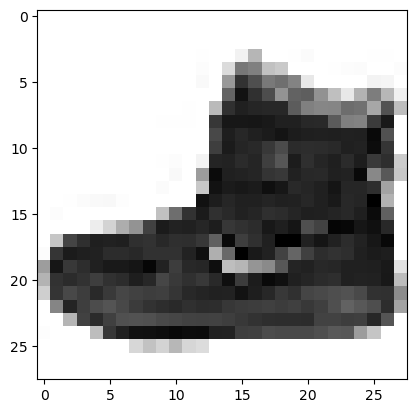

In [ ]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [ ]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # change the dimension orders to match what matplotlib expect (channels last, not first)
    if fc.hasattrs(im, ('cpu','permute')):
        im = im.cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    # handle black and white images    
    if im.shape[-1]==1: im=im[...,0]
    # matplotlibs options
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

We passed `**kwargs` to the function, and also used `@fastcore.delegates(plt.Axes.imshow)` to also get the help from matplotlib

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



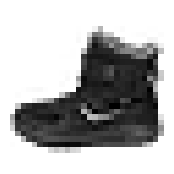

In [ ]:
show_image(img, figsize=(2,2));

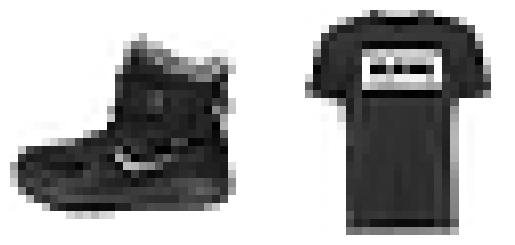

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
from nbdev.showdoc import show_doc

In [ ]:
show_doc(subplots)

---

[source](https://github.com/fastai/course22p2/blob/master/miniai/datasets.py#L55){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

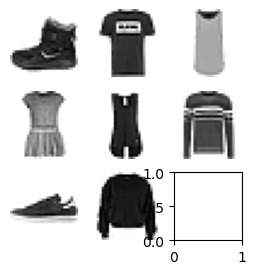

In [ ]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

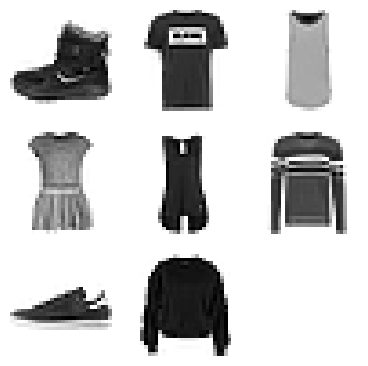

In [ ]:
fig,axs = get_grid(8, nrows=3, imsize=1.5)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int=1, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
yb = b['label']
lbls = yb[:8]

In [ ]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

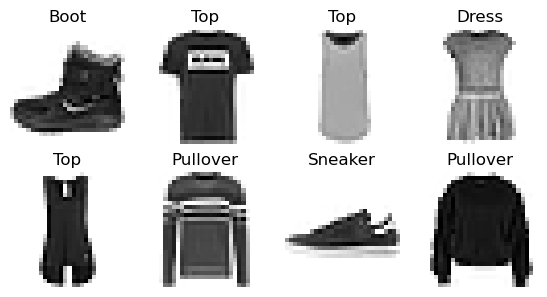

In [ ]:
show_images(imgs, imsize=1.7, titles=titles)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()